In [2]:
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
import json
import time
import pprint
import matplotlib.pyplot as plt
import datetime as dt
from functools import reduce
import pandas as pd
import seaborn as sns

session = Session()

#session.headers.update(headers)

In [3]:

def set_params(days:int, interval=['hourly', 'daily', 'minutely']):
    parameters =  {
        "vs_currency": "usd",
        "days": days,
        "interval": interval
    }
    return parameters

def check_rounding(time_col):
    diff = (time_col[1] - time_col[0]).total_seconds()
    if diff < 600:
        return time_col.dt.round('5min'), "rounded_minutes"
    elif diff > 80000:
        return time_col.dt.round('d'), "rounded_day"
    else:
        return time_col.dt.round('h'), "rounded_hour"

## The data doesn't come at exactly the same time it seems
## so we have to round
def convert_price_to_df(data, coin:str):
    time_col = coin+'_time'
    prices = data.get("prices")
    df = pd.DataFrame(prices, columns = [time_col, coin+'_price'])
    df[time_col] = pd.to_datetime(df[time_col], unit='ms')
    col, round_time = check_rounding(df[time_col])
    df[round_time] = col
    df.drop(df.tail(1).index,inplace=True)
    return df, round_time


def get_data_today(coin, day, interval):
    url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart'
    try:
        response = session.get(url, params=set_params(days=day, interval=interval))
        data = json.loads(response.text)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    else:
        return data

def convert_date(date):
    try:
        d = pd.to_datetime(date)
    except TypeError as e:
        print(e, "Please put in a proper date and time")
    else:
        return time.mktime(d.timetuple())

def get_data_range(coin, from_date, to_date):
    url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'
    from_converted = convert_date(from_date)
    to_converted = convert_date(to_date)
    params = {
        "vs_currency": "usd",
        "from": from_converted,
        "to": to_converted
    }
    try:
        response = session.get(url, params=params)
        data = json.loads(response.text)
    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(e)
    else:
        return data

# added lags to the data
# 

def coin_prices(coins: list, days_back: int, interval=['hourly', 'daily', 'minutely']):
    dfs = []
    prices = []
    for coin in coins:
        data = get_data_today(coin, days_back, interval)
        prices.append(data)
    for i, data in enumerate(prices):
        df, rounded_time = convert_price_to_df(data, coins[i])
        dfs.append(df)
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=[rounded_time]), dfs)
    return df_merged, rounded_time

def coin_prices_range(coins: list, from_date: int, to_date: int):
    dfs = []
    prices = []
    i= 0
    for coin in coins:
        data = get_data_range(coin, from_date, to_date)
        prices.append(data)
        i+=1
    for i, data in enumerate(prices):
        df, rounded_time = convert_price_to_df(data, coins[i])
        dfs.append(df)
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=[rounded_time]), dfs)
    return df_merged, rounded_time

def corr_from_today(coins, days_back: int, interval=['hourly', 'daily', 'minutely']):
    df, rounded_time = coin_prices(coins, days_back=days_back, interval=interval)
    interv = rounded_time.split('_')
    corr = df.corr()
    ax = plt.axes()
    ax.set_title(f"Correlation of coins on {interv[1]}ly intervals going back {days_back} days")
    return df, corr, sns.heatmap(corr, annot=True, cmap='Greens', ax=ax, xticklabels=coins, yticklabels=coins)

def corr_from_range(coins, from_date, to_date):
    df, rounded_time = coin_prices_range(coins, from_date, to_date)
    interv = rounded_time.split('_')
    corr = df.corr()
    ax = plt.axes()
    ax.set_title(f"Correlation of coins on intervals of {interv[1]}\nfrom {from_date} to {to_date}")
    return df, corr, sns.heatmap(corr, annot=True, cmap='Greens', ax=ax, xticklabels=coins, yticklabels=coins)


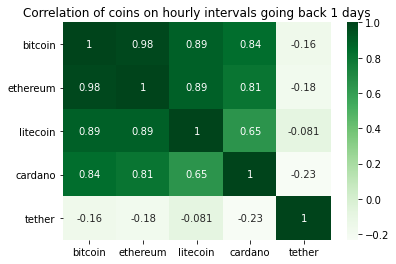

In [5]:
coins = ['bitcoin', 'ethereum', 'litecoin', 'cardano', 'tether']
df, corr, map = corr_from_today(coins, days_back=1, interval='hourly')

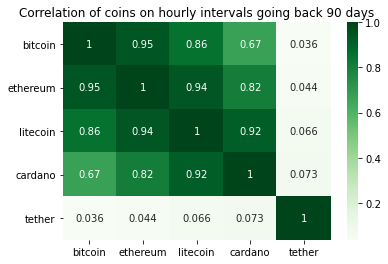

In [10]:
df, corr, map = corr_from_today(coins, days_back=90, interval='minutely')

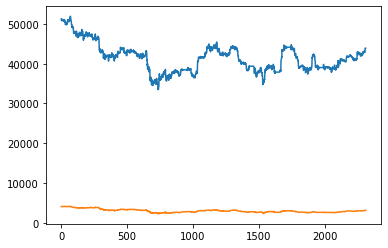

In [13]:
plt.plot(df.bitcoin_price)
plt.plot(df.ethereum_price)

In [34]:
df.head()

,bitcoin_time,bitcoin_price,rounded_hour,ethereum_time,ethereum_price,litecoin_time,litecoin_price,cardano_time,cardano_price,tether_time,tether_price
0,2022-03-20 14:03:24.775,41546.739372,2022-03-20 14:00:00,2022-03-20 14:03:41.915,2878.855642,2022-03-20 14:04:27.644,112.987836,2022-03-20 14:01:38.920,0.883089,2022-03-20 14:01:37.878,1.000939
1,2022-03-20 15:02:04.572,41450.358783,2022-03-20 15:00:00,2022-03-20 15:04:12.575,2864.795493,2022-03-20 15:03:16.141,112.915640,2022-03-20 15:03:35.590,0.878565,2022-03-20 15:03:23.661,1.001122
2,2022-03-20 16:02:05.474,41399.313923,2022-03-20 16:00:00,2022-03-20 16:00:59.903,2857.997558,2022-03-20 16:02:23.606,112.665815,2022-03-20 16:00:46.085,0.876826,2022-03-20 16:05:14.805,1.001119
3,2022-03-20 17:01:54.146,41335.613428,2022-03-20 17:00:00,2022-03-20 17:03:08.815,2852.432893,2022-03-20 17:02:05.082,112.740763,2022-03-20 17:03:01.552,0.877238,2022-03-20 17:04:00.240,1.000164
4,2022-03-20 18:01:51.743,41029.135518,2022-03-20 18:00:00,2022-03-20 18:02:02.155,2827.022687,2022-03-20 18:01:29.802,112.087158,2022-03-20 18:03:49.665,0.866868,2022-03-20 18:02:14.847,1.000208


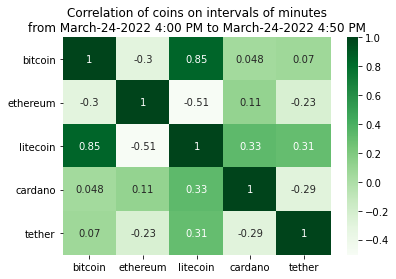

In [7]:
df, corr, map = corr_from_range(coins, "March-24-2022 4:00 PM", "March-24-2022 4:50 PM")

<AxesSubplot:>

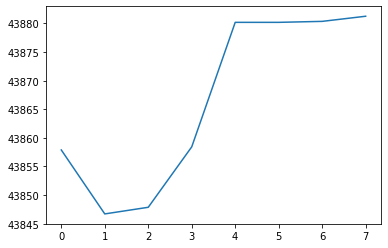

In [9]:
df.bitcoin_price.plot()